In [1]:
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Rescaling, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

In [2]:
def load_spectrograms(path, read_spec_files=False):

    if read_spec_files:    
        spectrograms = {}
        for i,f in enumerate(files):
            if i%100==0: print(i,', ',end='')
            tmp = pd.read_parquet(f'{path}//{f}')
            name = int(f.split('.')[0])
            spectrograms[name] = tmp.iloc[:,1:].values
    else:
        spectrograms = np.load(f"{path}", allow_pickle=True).item()
    return spectrograms

In [3]:
def get_column_names():
    columns = []
    regions = ['LL_', 'RL_', 'LP_', 'RP_']
    increments = [
        0.59, 0.78, 0.98, 1.17, 1.37, 1.56, 1.76, 1.95, 2.15, 2.34,
        2.54, 2.73, 2.93, 3.13, 3.32, 3.52, 3.71, 3.91, 4.1, 4.3,
        4.49, 4.69, 4.88, 5.08, 5.27, 5.47, 5.66, 5.86, 6.05, 6.25,
        6.45, 6.64, 6.84, 7.03, 7.23, 7.42, 7.62, 7.81, 8.01, 8.2,
        8.4, 8.59, 8.79, 8.98, 9.18, 9.38, 9.57, 9.77, 9.96, 10.16,
        10.35, 10.55, 10.74, 10.94, 11.13, 11.33, 11.52, 11.72, 11.91,
        12.11, 12.3, 12.5, 12.7, 12.89, 13.09, 13.28, 13.48, 13.67,
        13.87, 14.06, 14.26, 14.45, 14.65, 14.84, 15.04, 15.23, 15.43,
        15.63, 15.82, 16.02, 16.21, 16.41, 16.6, 16.8, 16.99, 17.19,
        17.38, 17.58, 17.77, 17.97, 18.16, 18.36, 18.55, 18.75, 18.95,
        19.14, 19.34, 19.53, 19.73, 19.92
    ]

    for r in regions:
        for i in increments:
            columns.extend([f'{r}{i}'])
    return columns

def get_spect_df(spectrograms):
    columns = get_column_names()
    dataframes = {}
    for key in spectrograms:
        subset_array = spectrograms[key][:300]
        df = pd.DataFrame(subset_array, columns=columns)
        dataframes[key] = df
    return dataframes

In [4]:
def get_spectrogram_image(df_spect):
    img_data_list = []
    split_spect = {
        "LL": df_spect.filter(regex='^LL', axis=1),
        "RL": df_spect.filter(regex='^RL', axis=1),
        "RP": df_spect.filter(regex='^RP', axis=1),
        "LP": df_spect.filter(regex='^LP', axis=1),
    }

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    plt.subplots_adjust(wspace=0, hspace=0)
    axes = axes.flatten()
    label_interval = 5
    for i, split_name in enumerate(split_spect.keys()):
        ax = axes[i]
        ax.axis('off')
        img = ax.imshow(np.log(split_spect[split_name] + 1e-10).T, cmap='viridis', aspect='auto', origin='lower')
    
    canvas = FigureCanvasAgg(plt.gcf())
    canvas.draw()
    img_array = np.array(canvas.get_renderer().buffer_rgba())
    plt.close()

    return img_array

In [5]:
PATH = r'C:\Users\zzelk\OneDrive\Desktop\harmful_brain_activity_classification\train_data\specs.npy'
spectrograms = load_spectrograms(PATH)
dataframes = get_spect_df(spectrograms)

In [6]:
PATH = r'C:\Users\zzelk\OneDrive\Desktop\harmful_brain_activity_classification\train_data\train.csv\train.csv'
metadata = pd.read_csv(PATH)
metadata.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [7]:
labels = metadata['expert_consensus']
labels.value_counts()

expert_consensus
Seizure    20933
GRDA       18861
Other      18808
GPD        16702
LRDA       16640
LPD        14856
Name: count, dtype: int64

In [22]:
labels_encoded = pd.get_dummies(labels, dtype='int')

In [9]:
# example 
img = get_spectrogram_image(dataframes[353733])
img.shape

(1200, 1500, 4)

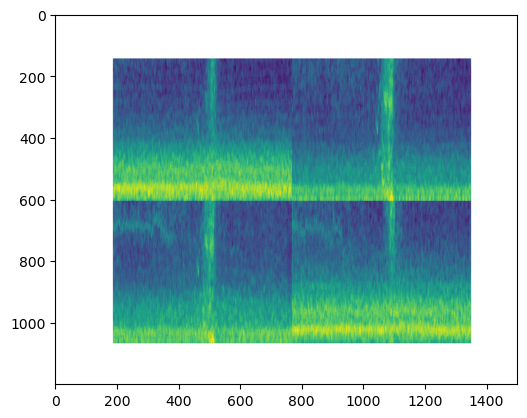

In [10]:
plt.imshow(img)
plt.show()

In [23]:
keys = list(dataframes.keys())[:200]
subset_dataframes = {key: dataframes[key] for key in keys}
subset_labels = labels_encoded[:200]

# not enough memory to add all images to X, so using a subset instead
X = np.array([get_spectrogram_image(subset_dataframes[key]) for key in subset_dataframes.keys()])
X.shape, subset_labels.shape

((200, 1200, 1500, 4), (200, 6))

In [24]:
subset_labels.shape

(200, 6)

In [25]:
X_train, X_test, labels_train, labels_test = train_test_split(X, subset_labels, test_size=0.2)
X_train.shape, X_test.shape, labels_train.shape, labels_test.shape

((160, 1200, 1500, 4), (40, 1200, 1500, 4), (160, 6), (40, 6))

In [26]:
model = Sequential([
    Rescaling(1/255, input_shape=(1200, 1500, 4)),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

model.input_shape, model.output_shape

((None, 1200, 1500, 4), (None, 6))

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 1200, 1500, 4)     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 1198, 1498, 64)    2368      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 599, 749, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 597, 747, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 298, 373, 64)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 296, 371, 64)     

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
callback = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=5)
history = model.fit(X_train, labels_train, validation_split=0.2, batch_size=16, epochs=30, callbacks=[callback])

Epoch 1/30
8/8 [==============================] - 953s 118s/step - loss: 13.3377 - accuracy: 0.1953 - val_loss: 1.6843 - val_accuracy: 0.1562
Epoch 2/30
4/8 [==============>...............] - ETA: 6:56 - loss: 1.7573 - accuracy: 0.2656

KeyboardInterrupt: 